# 5장. 차원 축소를 사용한 데이터 압축

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch05/ch05.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch05/ch05.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

`watermark`는 주피터 노트북에 사용하는 파이썬 패키지를 출력하기 위한 유틸리티입니다. `watermark` 패키지를 설치하려면 다음 셀의 주석을 제거한 뒤 실행하세요.

In [ ]:
#!pip install watermark

In [1]:
%load_ext watermark
%watermark -u -d -p numpy,scipy,matplotlib,sklearn

last updated: 2019-04-26 

numpy 1.16.3
scipy 1.2.1
matplotlib 3.0.3
sklearn 0.20.3


# 주성분 분석을 통한 비지도 차원 축소

## 주성분 추출 단계

In [2]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

# UCI 머신 러닝 저장소에서 Wine 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요.

# df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


70%는 훈련 세트로 30%는 테스트 세트로 나눕니다.

In [3]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

데이터를 표준화합니다.

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

공분산 행렬의 고윳값 분해

In [5]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\n고윳값 \n%s' % eigen_vals)


고윳값 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


## 총분산과 설명된 분산

In [6]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [7]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<Figure size 640x480 with 1 Axes>

## 특성 변환

In [8]:
# (고윳값, 고유벡터) 튜플의 리스트를 만듭니다
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# 높은 값에서 낮은 값으로 (고윳값, 고유벡터) 튜플을 정렬합니다
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [9]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('투영 행렬 W:\n', w)

투영 행렬 W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [10]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

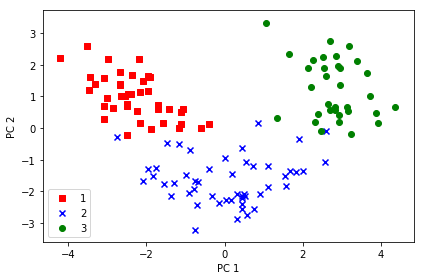

In [11]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## 사이킷런의 주성분 분석

**노트**

이어지는 네 개의 셀은 책에 없는 내용입니다. 사이킷런에서 앞의 PCA 구현 결과를 재현하기 위해 추가했습니다:

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

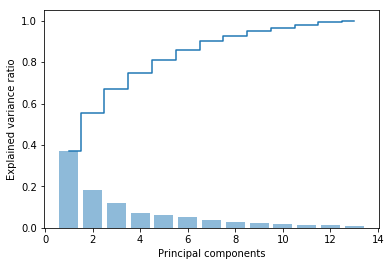

In [13]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [14]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

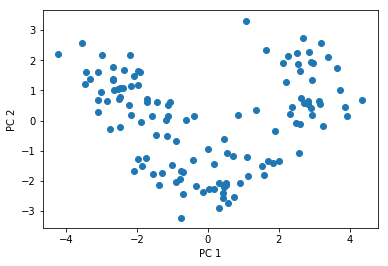

In [15]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 준비합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 클래스 샘플을 표시합니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap.colors[idx],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

처음 두 개의 주성분을 사용하여 로지스틱 회귀 분류기를 훈련합니다.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(solver='liblinear', multi_class='auto')
lr = lr.fit(X_train_pca, y_train)

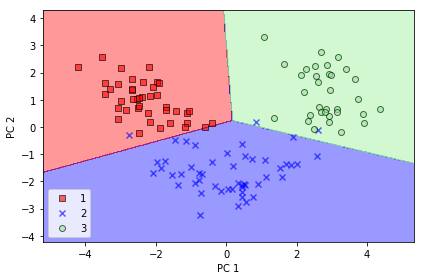

In [18]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

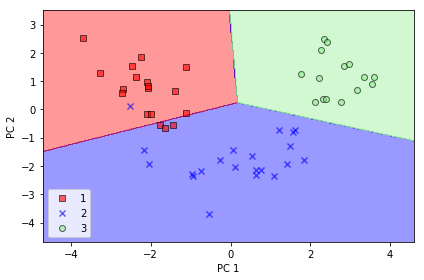

In [19]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [20]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

# 선형 판별 분석을 통한 지도방식의 데이터 압축

## 산포 행렬 계산

각 클래스이 평균 벡터를 계산합니다:

In [21]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



클래스 내 산포 행렬을 계산합니다:

In [22]:
d = 13 # 특성의 수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('클래스 내의 산포 행렬: %sx%s' % (S_W.shape[0], S_W.shape[1]))

클래스 내의 산포 행렬: 13x13


클래스가 균일하게 분포되어 있지 않기 때문에 공분산 행렬을 사용하는 것이 더 낫습니다:

In [23]:
print('클래스 레이블 분포: %s' 
      % np.bincount(y_train)[1:])

클래스 레이블 분포: [41 50 33]


In [24]:
d = 13  # 특성의 수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T, bias=True)
    S_W += class_scatter
print('스케일 조정된 클래스 내의 산포 행렬: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

스케일 조정된 클래스 내의 산포 행렬: 13x13


클래스 간 산포 행렬을 계산합니다:

In [25]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)  # 열 벡터로 만들기
d = 13  # 특성의 수
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # 열 벡터로 만들기
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('클래스 간의 산포 행렬: %sx%s' % (S_B.shape[0], S_B.shape[1]))

클래스 간의 산포 행렬: 13x13


## 새로운 특성 부분 공간을 위해 선형 판별 벡터 선택하기

행렬 $S_W^{-1}S_B$의 일반적인 고윳값 분해 문제를 풉니다:

In [26]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

고윳값의 역순으로 고유 벡터를 정렬합니다:

In [27]:
# (고윳값, 고유벡터) 튜플의 리스트를 만듭니다.
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# (고윳값, 고유벡터) 튜플을 큰 값에서 작은 값 순서대로 정렬합니다.
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# 고윳값의 역순으로 올바르게 정렬되었는지 확인합니다.

print('내림차순의 고윳값:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

내림차순의 고윳값:

358.0042070133658
177.07768640666217
2.842170943040401e-14
2.416464785473244e-14
2.1954926639581513e-14
2.1954926639581513e-14
2.036793867039433e-14
2.036793867039433e-14
1.8639642080179956e-14
1.4017013569391021e-14
1.4017013569391021e-14
3.5106142861573525e-15
2.728065685424338e-15


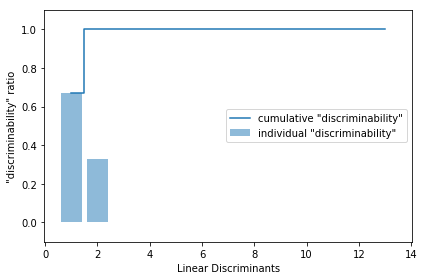

In [28]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [29]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('행렬 W:\n', w)

행렬 W:
 [[-0.1484 -0.4093]
 [ 0.091  -0.1583]
 [-0.0168 -0.3536]
 [ 0.1487  0.322 ]
 [-0.0165 -0.0813]
 [ 0.1912  0.0841]
 [-0.7333  0.2828]
 [-0.0751 -0.0099]
 [ 0.002   0.0902]
 [ 0.2953 -0.2168]
 [-0.0327  0.274 ]
 [-0.3539 -0.0133]
 [-0.3918 -0.5954]]


## 새로운 특성 공간으로 샘플 투영하기

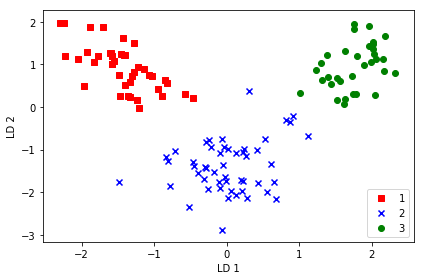

In [30]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## LDA via scikit-learn

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

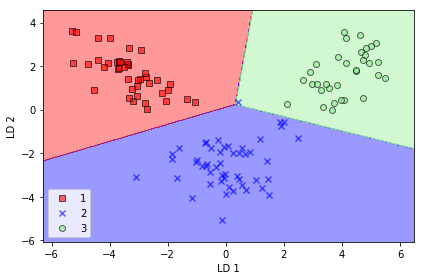

In [32]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', multi_class='auto')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

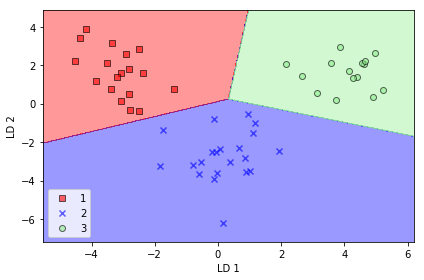

In [33]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

역주 #####

In [34]:
y_uniq, y_count = np.unique(y_train, return_counts=True)
priors = y_count / X_train_std.shape[0]
priors

array([0.3306, 0.4032, 0.2661])

$\sigma_{jk} = \frac{1}{n} \sum_{i=1}^n (x_j^{(i)}-\mu_j)(x_k^{(i)}-\mu_k)$

$m = \sum_{i=1}^c \frac{n_i}{n} m_i$

$S_W = \sum_{i=1}^c \frac{n_i}{n} S_i = \sum_{i=1}^c \frac{n_i}{n} \Sigma_i$

In [35]:
s_w = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, label in enumerate(y_uniq):
    # 1/n로 나눈 공분산 행렬을 얻기 위해 bias=True로 지정합니다.
    s_w += priors[i] * np.cov(X_train_std[y_train == label].T, bias=True)

$ S_B = S_T-S_W = \sum_{i=1}^{c}\frac{n_i}{n}(m_i-m)(m_i-m)^T $

In [36]:
s_b = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1].shape[0]
    mean_vec = mean_vec.reshape(-1, 1)
    s_b += priors[i] * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

In [37]:
import scipy
ei_val, ei_vec = scipy.linalg.eigh(s_b, s_w)
ei_vec = ei_vec[:, np.argsort(ei_val)[::-1]]
ei_vec /= np.linalg.norm(ei_vec, axis=0)

In [38]:
lda_eigen = LDA(solver='eigen')
lda_eigen.fit(X_train_std, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)

In [39]:
# 클래스 내의 산포 행렬은 covariance_ 속성에 저장되어 있습니다.
np.allclose(s_w, lda_eigen.covariance_)

True

In [40]:
Sb = np.cov(X_train_std.T, bias=True) - lda_eigen.covariance_
np.allclose(Sb, s_b)

True

In [41]:
np.allclose(lda_eigen.scalings_[:, :2], ei_vec[:, :2])

True

In [42]:
np.allclose(lda_eigen.transform(X_test_std), np.dot(X_test_std, ei_vec[:, :2]))

True

#####

# 커널 PCA를 사용하여 비선형 매핑하기

## 파이썬으로 커널 PCA 구현하기

In [43]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF 커널 PCA 구현

    매개변수
    ------------
    X: {넘파이 ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      RBF 커널 튜닝 매개변수
        
    n_components: int
      반환할 주성분 개수

    반환값
    ------------
     X_pc: {넘파이 ndarray}, shape = [n_samples, k_features]
       투영된 데이터셋

    """
    # MxN 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산합니다.
    sq_dists = pdist(X, 'sqeuclidean')

    # 샘플 간의 거리를 정방 대칭 행렬로 변환합니다.
    mat_sq_dists = squareform(sq_dists)

    # 커널 행렬을 계산합니다.
    K = exp(-gamma * mat_sq_dists)

    # 커널 행렬을 중앙에 맞춥니다.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # 중앙에 맞춰진 커널 행렬의 고윳값과 고유벡터를 구합니다.
    # scipy.linalg.eigh 함수는 오름차순으로 반환합니다.
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 최상위 k 개의 고유벡터를 선택합니다(결과값은 투영된 샘플입니다).
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    return X_pc

### 예제 1: 반달 모양 구분하기

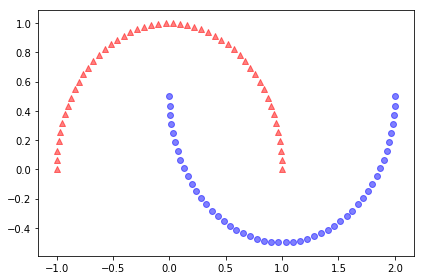

In [44]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

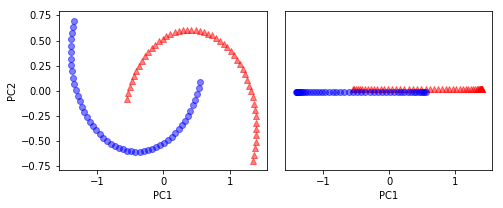

In [45]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

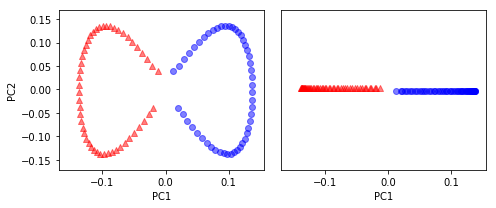

In [46]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

### 예제 2: 동심원 분리하기

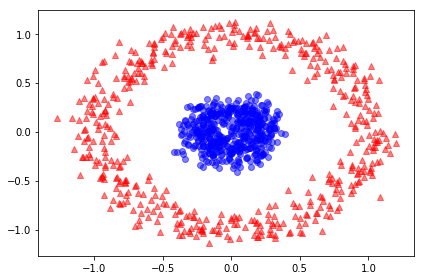

In [47]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

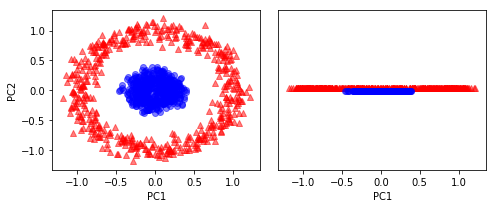

In [48]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

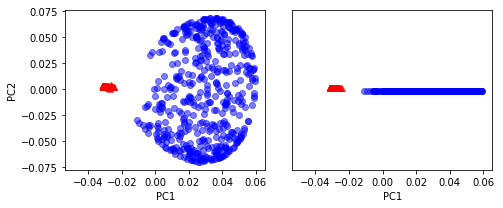

In [49]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

## 새로운 데이터 포인트 투영하기

In [50]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF 커널 PCA 구현

    매개변수
    ------------
    X: {넘파이 ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      RBF 커널 튜닝 매개변수
        
    n_components: int
      반환할 주성분 개수

    Returns
    ------------
     alphas: {넘파이 ndarray}, shape = [n_samples, k_features]
       투영된 데이터셋
     
     lambdas: list
       고윳값

    """
    # MxN 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산합니다.
    sq_dists = pdist(X, 'sqeuclidean')

    # 샘플 간의 거리를 정방 대칭 행렬로 변환합니다.
    mat_sq_dists = squareform(sq_dists)

    # 커널 행렬을 계산합니다.
    K = exp(-gamma * mat_sq_dists)

    # 커널 행렬을 중앙에 맞춥니다.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # 중앙에 맞춰진 커널 행렬의 고윳값과 고유 벡터를 구합니다.
    # scipy.linalg.eigh 함수는 오름차순으로 반환합니다.
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 최상위 k 개의 고유 벡터를 선택합니다(투영 결과).
    alphas = np.column_stack([eigvecs[:, i]
                              for i in range(n_components)])

    # 고유 벡터에 상응하는 고윳값을 선택합니다.
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

In [51]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [52]:
x_new = X[25]
x_new

array([1.8713, 0.0093])

In [53]:
x_proj = alphas[25] # 원본 투영
x_proj

array([0.0788])

In [54]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# 새로운 데이터포인트를 투영합니다.
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj 

array([0.0788])

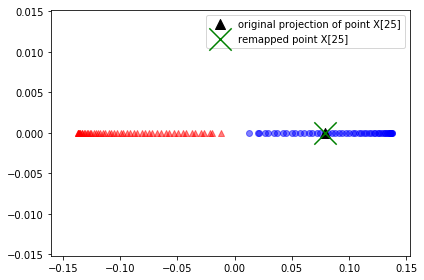

In [55]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='remapped point X[25]', marker='x', s=500)
plt.legend(scatterpoints=1)

plt.tight_layout()
plt.show()

## 사이킷런의 커널 PCA

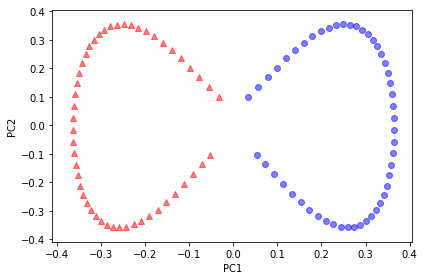

In [56]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()